In [178]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [179]:
A1,A2,A3 = 60 * torch.rand(3,10)

In [180]:
A4 = torch.max(A1,A2)

In [197]:
t0 = 96
x = torch.arange(1,t0+24).type(torch.float).unsqueeze(0)

In [199]:
fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*x[0,0:12]/6)+72 , A2.unsqueeze(1)*torch.sin(np.pi*x[0,12:24]/6)+72 , A3.unsqueeze(1)*torch.sin(np.pi*x[0,24:t0]/6)+72 , A4.unsqueeze(1)*torch.sin(np.pi*x[0,t0:t0+24]/12)+72],1)

In [213]:
torch.cat(3*[x]).shape

torch.Size([3, 119])

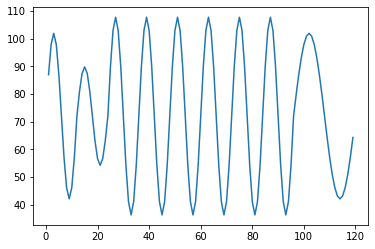

In [203]:
plt.plot(x[0].numpy(),fx[5,:].numpy())
plt.show()

In [146]:
def chunk_time_series(t0,window_size,y):
    window_size = t0+1
    y_chunked = []
    y_left = []
    for t in range(0,fx.shape[1]-window_size):
        y_chunked.append(y[:,t:t+window_size])
        y_left.append(y[:,t+window_size])
    return torch.cat(y_chunked,0),torch.cat(y_left)

In [83]:
from torch.utils.data import Dataset

In [250]:
print("{}{}".format(*list(x.shape)))

1119


In [248]:
x.shape.values

AttributeError: 'torch.Size' object has no attribute 'values'

In [257]:
class time_series(Dataset):
    """synthetic time series dataset from section 5.1"""
    
    def __init__(self,t0=96,window_size=96,N=4500,transform=None):
        """
        Args:
            t0: previous t0 data points to predict from
            window_size: how many points to use for inference of next time point
            N: number of data points
            transform: any transformations to be applied to time series
        """
        self.t0 = t0
        self.window_size = window_size
        self.N = N
        self.transform = None
        
        A1,A2,A3 = 60 * torch.rand(3,N)
        A4 = torch.max(A1,A2)

        x = torch.cat(N*[torch.arange(1,t0+24).type(torch.float).unsqueeze(0)])
        
        fx = torch.cat([A1.unsqueeze(1)*torch.sin(np.pi*x[0,0:12]/6)+72 ,
                        A2.unsqueeze(1)*torch.sin(np.pi*x[0,12:24]/6)+72 ,
                        A3.unsqueeze(1)*torch.sin(np.pi*x[0,24:t0]/6)+72 ,
                        A4.unsqueeze(1)*torch.sin(np.pi*x[0,t0:t0+24]/12)+72],1)
        
        self.x,self.x_next = chunk_time_series(t0,window_size,x)
        self.fx,self.fx_next = chunk_time_series(t0,window_size,fx)
        
        print("x: {}*{}".format(*list(self.x.shape)),
              "x_next: {}".format(*list(self.x_next.shape)),
              "fx: {}*{}".format(*list(self.fx.shape)),
              "fx_next: {}".format(*list(self.fx_next.shape)))
        
        
    def __len__(self):
        return len(self.fx)
    
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        sample = {"x":self.x[idx,:],"x_next":self.x_next[idx],"fx":self.fx[idx,:],"fx_next":self.fx_next[idx]}
        
        
        if self.transform:
            sample=self.transform(sample)
            
        return sample

In [258]:
dataset = time_series(t0,window_size,100)

x: 2200*97 x_next: 2200 fx: 2200*97 fx_next: 2200


In [237]:
dataset.fx

tensor([[ 92.1662, 106.9289, 112.3324,  ...,  55.0369,  72.0000,  82.4388],
        [ 87.4627,  98.7822, 102.9254,  ...,  70.4395,  72.0000,  87.4231],
        [ 76.1220,  79.1395,  80.2440,  ...,  61.9302,  72.0000,  84.4966],
        ...,
        [ 31.4863,  48.6094,  72.0000,  ...,  31.4862,  38.9207,  48.6094],
        [ 54.7873,  62.0622,  72.0000,  ...,  54.7872,  57.9459,  62.0622],
        [ 70.4043,  71.0787,  72.0000,  ...,  32.5169,  39.7622,  49.2044]])

In [230]:
dataset[2199]

{'x': tensor([ 22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
          34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
          46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
          58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.,
          70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,  80.,  81.,
          82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,  93.,
          94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103., 104., 105.,
         106., 107., 108., 109., 110., 111., 112., 113., 114., 115., 116., 117.,
         118.]),
 'x_next': tensor(119.),
 'fx': tensor([ 56.6255,  63.1235,  72.0000,  87.3732,  98.6272, 102.7464,  98.6272,
          87.3732,  72.0000,  56.6268,  45.3728,  41.2536,  45.3728,  56.6268,
          72.0000,  87.3732,  98.6272, 102.7464,  98.6271,  87.3732,  72.0000,
          56.6268,  45.3728,  41.2536,  45.3728,  56.6268,  72

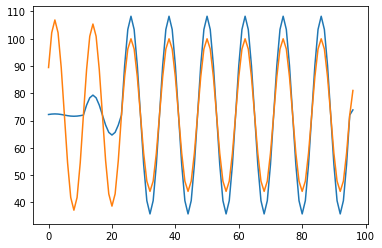

In [231]:
plt.plot(dataset.fx[0,:].numpy())
plt.plot(dataset.fx[1,:].numpy())